In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread("sharif.jpg",1)
# cv2.imshow("img",image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

In [3]:
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Facial landmarks
result = face_mesh.process(rgb_image)
print(result)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [4]:
allpoints=[]
height, width, _ = image.shape

for facial_landmarks in result.multi_face_landmarks:
    
    for i in range(460,468):
        pt1 = facial_landmarks.landmark[i]
       
        x = int(pt1.x * width)
        y = int(pt1.y * height)
    
        allpoints.append((x,y))
        cv2.circle(image, (x, y), 2, (100, 100, 0), -1)
print(allpoints)

# cv2.imshow("Image", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[(342, 299), (330, 297), (328, 299), (336, 233), (332, 235), (331, 236), (379, 233), (383, 231)]


In [5]:
mask = np.zeros(image.shape, dtype='uint8')
mask = cv2.fillPoly(mask, [np.array(allpoints)], (255, 255, 255))

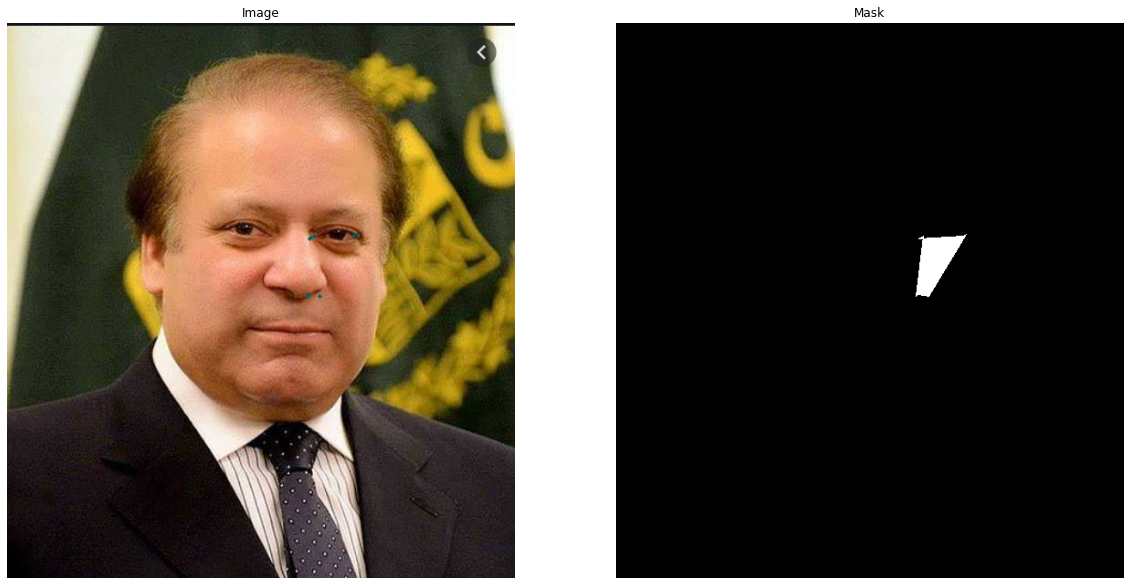

In [6]:
plt.figure(figsize=[20,20])
plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Image");plt.axis('off')
plt.subplot(122);plt.imshow(mask, cmap='gray');plt.title("Mask");plt.axis('off');

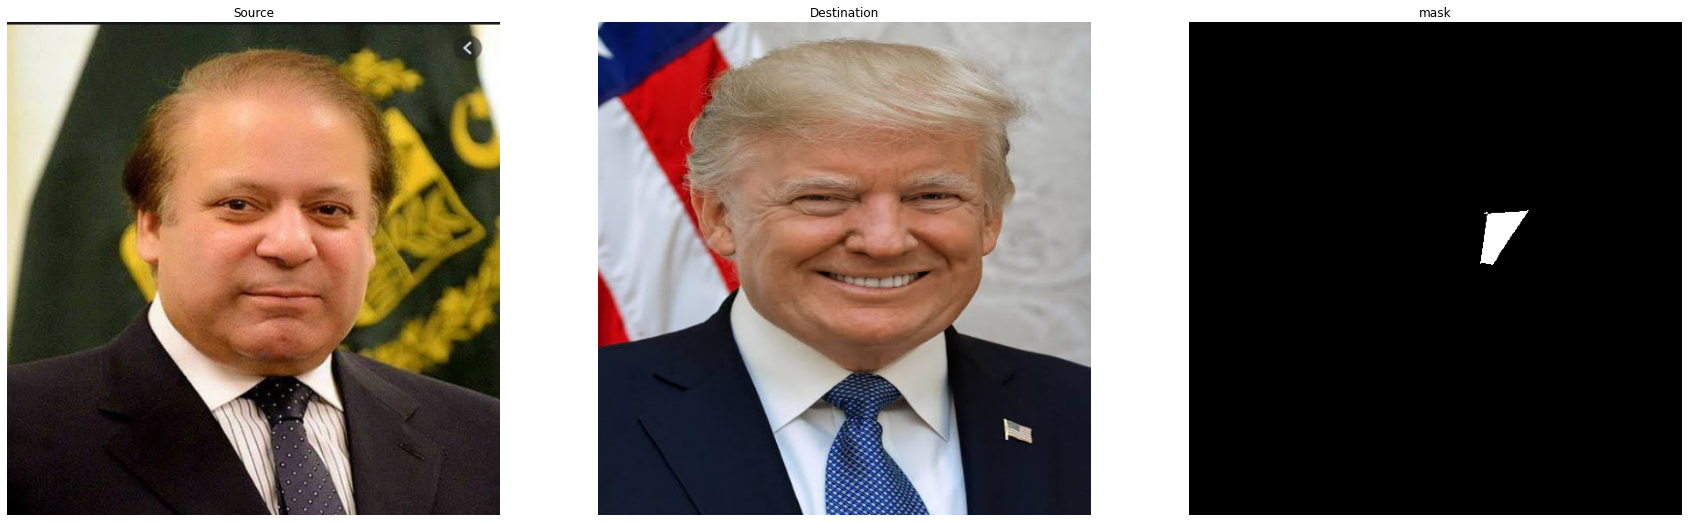

In [7]:
%matplotlib inline



destination = cv2.imread(  'trump.jpg',1)
source = cv2.imread("sharif.jpg",1)

size = (540,540)

# resize them to the same size (not required but for this example this makes our work easier)
destination = cv2.resize(destination, size)
source = cv2.resize(source, size)

# mask = cv2.imread(base_path + img_name.split('.')[0] + 'mask' + '.jpg',0 )
mask = cv2.resize(mask, size)

#this is to make sure we have no gray pixels (in outlines) all are either 0 or 255
ret, mask = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)

plt.figure(figsize=[30,30])
plt.subplot(131);plt.imshow(source[:,:,::-1]);plt.title("Source");plt.axis('off')
plt.subplot(132);plt.imshow(destination[:,:,::-1]);plt.title("Destination");plt.axis('off');
plt.subplot(133);plt.imshow(mask, cmap = 'gray');plt.title('mask');plt.axis('off');

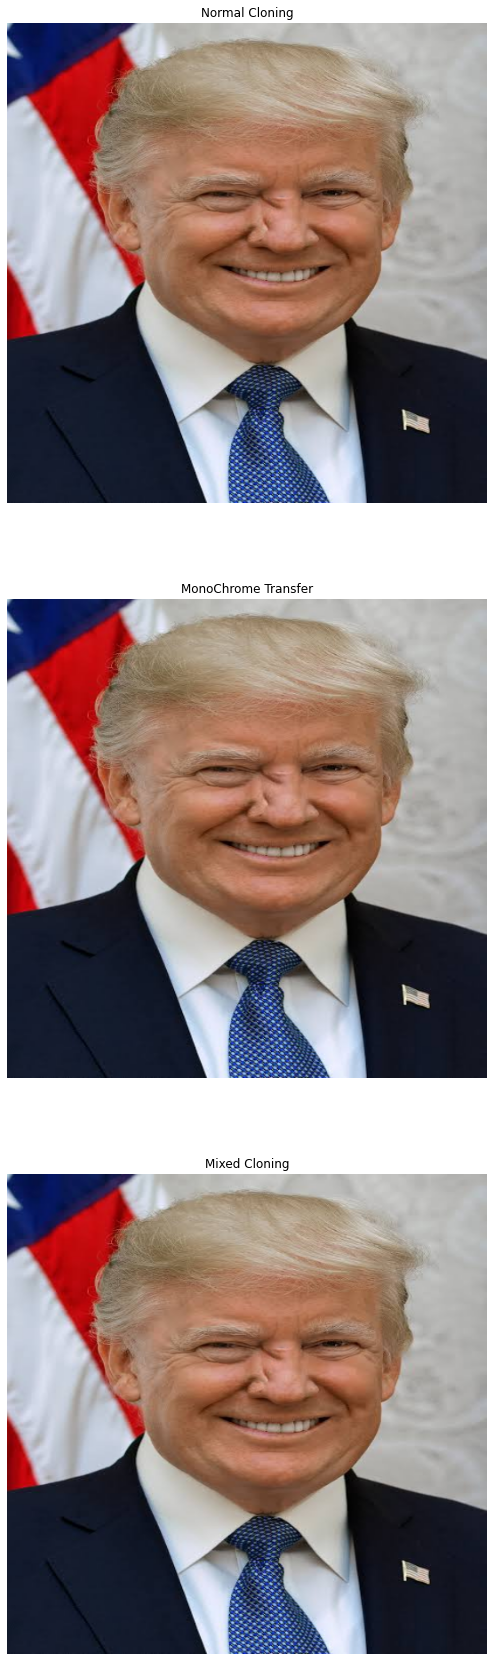

In [8]:
height_constant = -50
width_constant = 30
center_point = (size[0]//2 + width_constant ,size[1]//2  + height_constant)

cloned_image_normal = cv2.seamlessClone(source, destination, mask, center_point, cv2.NORMAL_CLONE)
cloned_image_mixed = cv2.seamlessClone( source,destination, mask, center_point, cv2.MIXED_CLONE)
Monochrome = cv2.seamlessClone(source, destination, mask, center_point, cv2.MONOCHROME_TRANSFER)

%matplotlib inline
plt.figure(figsize=[30,30])
plt.subplot(311);plt.imshow(cloned_image_normal[:,:,::-1]);plt.title("Normal Cloning");plt.axis('off')
plt.subplot(312);plt.imshow(Monochrome[:,:,::-1]);plt.title("MonoChrome Transfer");plt.axis('off');
plt.subplot(313);plt.imshow(cloned_image_mixed[:,:,::-1]);plt.title("Mixed Cloning");plt.axis('off');


In [9]:
def cloner(source,destination,mask=mask,manual=True,vis = True,full_image=False):
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    origninalsource = source.copy()
    
    # This piece of code handles the condition in which we als0 want the face image to be extracted
    if full_image:
        
        faces = face_cascade.detectMultiScale(source, 1.3, 5)        

        if len(faces) > 0:
            x,y,w,h=faces[0]
            source = source[y:y+h, x:x+w]

        # if face detection fails then maually crop out the image
        else:
            if manual:                
                r = cv2.selectROI(source)     
                source =  source[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
            else:
                return None
        
    # Load a generic mask that approximate an average face if no mask was provided
    if mask is None:
        mask = cv2.imread('commonmask.jpg',0 )

    # perform the face detection and extract the first face
    faces = face_cascade.detectMultiScale(destination, 1.3, 5)

    if len(faces) > 0:
        x,y,w,h=faces[0]
        faceroi = destination[y:y+h, x:x+w]
        # get the center of the face
        center_point = (x+w//2,y+h//2)

    # if face detection fails then maually crop out the image
    else:
        
        if manual: 
            r = cv2.selectROI(destination)   
            # get the width and height
            h = r[3]
            w = r[2]
            center_point = (x+w//2,y+h//2)
        else:
            return None

    # resize the source face and the mask according to the detected face
    size = (w,h)
    mask = cv2.resize(mask, size)
    source = cv2.resize(source, size)


    cloned_image_normal = cv2.seamlessClone(source, destination, mask, center_point, cv2.NORMAL_CLONE)
    Monochrome = cv2.seamlessClone(source, destination, mask, center_point, cv2.MONOCHROME_TRANSFER)

    if vis:
        plt.figure(figsize=[20,30])
        plt.subplot(221);plt.imshow(origninalsource[:,:,::-1]);plt.title("Source");plt.axis('off')
        plt.subplot(222);plt.imshow(destination[:,:,::-1]);plt.title("destination");plt.axis('off');
        plt.subplot(223);plt.imshow(cloned_image_normal[:,:,::-1]);plt.title("Normal Cloning");plt.axis('off')
        plt.subplot(224);plt.imshow(Monochrome[:,:,::-1]);plt.title("MonoChrome Transfer");plt.axis('off');

    return cloned_image_normal

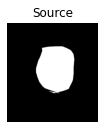